# Trabajo Práctico 2 - Código Fuente

### Joaquín Costa da Cunha - 104017
### Julián Stejman Peterbug - 102840


###### 1er Cuatrimestre 2020 - Análisis Numérico - Curso Tarela / Ezcurra / Poltarak

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-whitegrid')




In [2]:
corte_datos_viejos = '2020-04-29'  #Fecha hasta donde llegaban los datos de la entrega 2

df = pd.read_csv('Base Datos Nueva.csv') 
indonesia = df[df['iso_code'] == 'IDN'].reset_index(drop=True)

In [3]:
def aproximar_ceros(df):
    start = df[df['new_cases'] > 0].index.min()
    for i in range(start, df.index.max()):
        if df.iloc[i, 5] == 0:
            df.iloc[i, 5] = np.abs(df.iloc[i+1, 5] - df.iloc[i-1, 5] ) / 2
    return df

aproximar_ceros(indonesia)

idn = indonesia[indonesia['new_cases'] > 0].reset_index(drop=True)

casos_nuevos = idn['new_cases']
casos_totales = casos_nuevos.cumsum()
fechas = idn.date
dias = np.array(casos_nuevos.index)

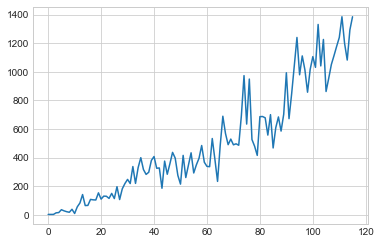

In [4]:
plt.plot(dias, casos_nuevos)

# Función de Avance del PVI (método RK2)

In [5]:
def avance_RK2(h, beta, gamma, dia_max, N, u0, v0, w0):
    
    def f1(u, v, beta, N=N):
        return - beta/N * u* v

    def f2(u, v, beta, gamma, N=N):
        return beta/N * u* v - gamma*v

    def f3(v, gamma):
        return gamma*v
    
    
    t = np.arange(0, dia_max+h, h)
    u = np.empty(len(t))
    u[0] = u0
    v = np.empty(len(t))
    v[0] = v0
    w = np.empty(len(t))
    w[0] = w0
    for n in range(len(t)-1):
        u_predictor = u[n] + h/2 * f1(u=u[n], v=v[n], beta=beta)
        v_predictor = v[n] + h/2 * f2(u=u[n], v=v[n], beta=beta, gamma=gamma)
        w_predictor = w[n] + h/2 * f3(v=v[n], gamma=gamma)
        
        u[n+1] = u[n] + h * f1(u=u_predictor, v=v_predictor, beta=beta)
        v[n+1] = v[n] + h * f2(u=u_predictor, v=v_predictor, beta=beta, gamma=gamma)
        w[n+1] = w[n] + h * f3(v=v_predictor, gamma=gamma)
        
    return t, u, v, w

In [6]:
def norma(l):
    return np.sqrt((l**2).sum())

def ecm_rel(l1, l2):
    '''Calcula el error relativo entre los vectores l1 y l2, tomando como valor de referencia a l1'''
    return norma(l2-l1) / norma(l1)

def error(datos, resultado, h, dia_max):
    '''Calcula el error al aproximar los datos reales con una solucion numerica de paso h'''
    resultado_diario = resultado[[int(n/h) for n in range(dia_max)]]
    return ecm_rel(datos, resultado_diario)

def refinar_calibracion(arr_gamma, arr_sigma, arr_N, arr_v0, datos, h=1, dia_max=116):
    '''Dada una red de valores para los parametros prueba todas las combinaciones posibles y devuelve la que tenga un menor ECM'''
    mejor_sigma = 0
    mejor_gamma = 0
    mejor_N = 0
    mejor_v0 = 0
    
    e = np.inf
    
    for N in arr_N:
        for v0 in arr_v0:
            u0 = N-v0
            for g in arr_gamma:
                for s in arr_sigma:
                    t, u, v, w = avance_RK2(h=h, beta=g*s, gamma=g, dia_max=dia_max, N=N, u0=u0, v0=v0, w0=0)
                    err = error(datos, v + w, h=h, dia_max=dia_max)
                    if  err < e:
                        e = err
                        mejor_sigma = s
                        mejor_N = N
                        mejor_v0 = v0
                        mejor_gamma= g

    mejor_beta = mejor_sigma * mejor_gamma
    return mejor_beta, mejor_gamma, mejor_sigma, mejor_N, mejor_v0, e   

In [7]:
def calibrar(gamma, sigma, N, v0):
    '''Con esta función se creó el gráfico interactivo para poder variar los parámetros'''
       
    u0 = N - v0           #Toda la poblacion es susceptible menos los dos infectados
    w0 = 0                #No hay muertos en el instante 0     
    
    t, u , v, w = avance_RK2(1, beta=sigma*gamma, gamma=gamma, dia_max=350, N=N, u0=u0, v0=v0, w0=w0)

    fig, ax = plt.subplots(1, 3, figsize=(14,8))

    grid= plt.GridSpec(2, 2, wspace=0.2, hspace=0.1)

    SIR = plt.subplot(grid[0, :])
    CT = plt.subplot(grid[1, 0])
    CN = plt.subplot(grid[1, 1])


    SIR.plot(t, u, c="C0")
    SIR.plot(t, v, c='red')
    SIR.plot(t, w, c='green')
    SIR.plot(t, v+w, c='C1')
    SIR.scatter(dias[:52], casos_totales[:52])


    CT.plot(t[:60], (v+w)[:60], c='C1')
    CT.scatter(dias[:52], casos_totales[:52])
    CT.plot(t[:60], v[:60], c='red')
    CT.plot(t[:60], w[:60], c='green')

    deltaS = np.empty(len(t))
    deltaS[0] = u[0] - u0
    for i in range(1, len(deltaS)):
        deltaS[i] = u[i-1] - u[i]

    CN.scatter(dias[:52], casos_nuevos[:52])
    CN.plot(t[:200], deltaS[:200])
    
    errCT = error(casos_totales[:52], (v+w)[:52], 1, 52)
    errCN = error(casos_nuevos[:52], deltaS[:52], 1, 52)
    SIR.text(0.75, 0.93, f'Error CT: {errCT}', transform=fig.transFigure)
    SIR.text(0.75, 0.9, f'Error CN: {errCN}', transform=fig.transFigure)
    
    return

interact(calibrar, gamma=(1/30, 1/5, 1/200), sigma=(1.5,3,0.03125), N=(250000, 1000000, 100000), v0=(1, 1000, 25))



interactive(children=(FloatSlider(value=0.11333333333333334, description='gamma', max=0.2, min=0.0333333333333…

<function __main__.calibrar(gamma, sigma, N, v0)>

In [8]:
class AnexoA:
    '''Esta clase va guardando en una DataFrame todos los valores que probamos para calibrar el modelo'''
    
    def __init__(self, name, set_datos='nuevos'):
        self.name = name
        try:
            self.registro = pd.read_csv(self.name + '.csv').iloc[:,1:]
            self.nfilas = len(self.registro)
        except FileNotFoundError: 
            self.registro = pd.DataFrame({'corridas': [],
                                      'min_g': [],
                                      'max_g': [],
                                      'min_s': [],
                                      'max_s': [],
                                      'min_N': [],
                                      'max_N': [],
                                      'min_v0': [],
                                      'max_v0': [],
                                      'Beta': [], 
                                      'Gamma': [],
                                      'Sigma': [],
                                      'N': [],
                                      'v0': [],
                                      'Error_CT': [],
                                      'Error_CN': []})
            self.nfilas = 0
        self.casos_totales = casos_totales
        self.casos_nuevos = casos_nuevos
        self.dia_max = 116
        if set_datos == 'viejos': 
            self.casos_totales = casos_totales[:52]
            self.casos_nuevos = casos_nuevos[:52]
            self.dia_max = 52
        
    def __getitem__(self, index):
        return self.registro.iloc[index]
    
    def __guardar(self):
        self.registro.to_csv(self.name + '.csv')
        return 
    
    def agregar_fila(self, arr_g, arr_s, arr_N, arr_v0, tol=20000):
        corridas = len(arr_g) * len(arr_s) * len(arr_N) * len(arr_v0)
        if corridas > tol: 
            print(f'Más de {tol} corridas. Va a tardar mucho.')
            return
        valores = np.array([corridas, min(arr_g), max(arr_g), min(arr_s), max(arr_s), min(arr_N), max(arr_N) ,min(arr_v0), max(arr_v0)])
        
        resultados = refinar_calibracion(arr_g, arr_s, arr_N, arr_v0, self.casos_totales, 1, self.dia_max)
        
        
        def calc_deltaS(b, g, N, v0, dia_max):
            t, u , v, w = avance_RK2(1, beta=b, gamma=g, dia_max=dia_max, N=N, u0=N-v0, v0=v0, w0=0)
            deltaS = np.empty(len(t))
            deltaS[0] = u[0] - (N - v0)
            for i in range(1, len(deltaS)):
                deltaS[i] = u[i-1] - u[i]
            return deltaS
        
        deltaS= calc_deltaS(resultados[0], resultados[1], resultados[3], resultados[4], self.dia_max)
        errorCN = np.array([error(self.casos_nuevos, deltaS, 1, self.dia_max)])
        
        fila = np.concatenate((valores, resultados, errorCN))
        self.registro.loc[self.nfilas] = fila
        self.nfilas +=1
        self.__guardar()
        return #self.plotear_fila(-1, 500)
    
    def plotear_fila(self, fila, hasta_dia):
        params = self.registro.iloc[fila]
        u0 = params.N - params.v0
        t, u, v, w = avance_RK2(1, beta=params.Beta, gamma=params.Gamma, dia_max=hasta_dia, N=params.N, u0=u0, v0=params.v0, w0=0)
        
        fig, ax = plt.subplots(1, 3, figsize=(14,8))

        grid= plt.GridSpec(2, 2, wspace=0.2, hspace=0.1)

        SIR = plt.subplot(grid[0, :])
        CT = plt.subplot(grid[1, 0])
        CN = plt.subplot(grid[1, 1])
              
        
        SIR.plot(t, u, c="C0")
        SIR.plot(t, v, c='red')
        SIR.plot(t, w, c='green')
        SIR.plot(t, v+w, c='C1')
        SIR.scatter(dias[:self.dia_max], casos_totales[:self.dia_max])


        CT.plot(t[:self.dia_max + 10], (v+w)[:self.dia_max + 10], c='C1')
        CT.scatter(dias[:self.dia_max], casos_totales[:self.dia_max])
        CT.plot(t[:self.dia_max + 10], v[:self.dia_max + 10], c='red')
        CT.plot(t[:self.dia_max + 10], w[:self.dia_max + 10], c='green')

        deltaS = np.empty(len(t))
        deltaS[0] = u[0] - u0
        for i in range(1, len(deltaS)):
            deltaS[i] = u[i-1] - u[i]

        CN.scatter(dias[:self.dia_max], casos_nuevos[:self.dia_max])
        CN.plot(t, deltaS)
        
    
        SIR.text(0.75, 0.93, f'Error CT: {params.Error_CT}', transform=fig.transFigure)
        SIR.text(0.75, 0.9, f'Error CN: {params.Error_CN}', transform=fig.transFigure)


    

# Calibración de los datos viejos

In [9]:
cal_viejos = AnexoA('AnexoA1_corregido', 'viejos')

cal_viejos.registro

,corridas,min_g,max_g,min_s,max_s,min_N,max_N,min_v0,max_v0,Beta,Gamma,Sigma,N,v0,Error_CT,Error_CN
0,24000.0,0.03,0.05,1.5,2.0,500000.0,700000.0,1.0,1000.0,0.097895,0.048947,2.000000,700000.0,421.631579,0.125409,0.310595
1,48000.0,0.03,0.05,1.5,2.5,700000.0,1000000.0,500.0,1000.0,0.082895,0.033158,2.500000,700000.0,500.000000,0.139682,0.316087
2,48000.0,0.03,0.05,1.5,2.5,700000.0,1000000.0,1.0,500.0,0.109654,0.047895,2.289474,700000.0,263.631579,0.090495,0.421865
3,48000.0,0.03,0.05,2.0,2.5,500000.0,900000.0,1.0,500.0,0.110776,0.048947,2.263158,500000.0,263.631579,0.089902,0.420543
4,48000.0,0.03,0.05,2.0,2.5,300000.0,900000.0,150.0,450.0,0.113158,0.050000,2.263158,300000.0,250.000000,0.088721,0.420706
5,33600.0,0.03,0.06,2.0,2.5,100000.0,300000.0,150.0,450.0,0.123000,0.060000,2.050000,100000.0,250.000000,0.081355,0.353798
6,12600.0,0.05,0.08,2.0,2.5,200000.0,300000.0,150.0,450.0,0.122105,0.061053,2.000000,200000.0,250.000000,0.085289,0.375538
7,12600.0,0.05,0.08,1.8,2.5,200000.0,300000.0,150.0,450.0,0.134837,0.072105,1.870000,200000.0,216.666667,0.083482,0.392603
8,63000.0,0.05,0.08,1.8,2.5,50000.0,300000.0,150.0,450.0,0.149392,0.078421,1.905000,50000.0,183.333333,0.065926,0.317461
9,6300.0,0.04,0.08,2.0,2.5,300000.0,300000.0,150.0,450.0,0.121379,0.060690,2.000000,300000.0,250.000000,0.086670,0.387515


In [10]:
arr_gamma = np.linspace(0.06, 0.10, 30)
arr_sigma = np.linspace(1.5, 2.5, 31)
arr_N = np.linspace(500000, 500000, 1)
arr_v0 = np.linspace(150, 450, 10)

#cal_viejos.agregar_fila(arr_gamma, arr_sigma, arr_N, arr_v0, tol=70000)
#cal_viejos.registro

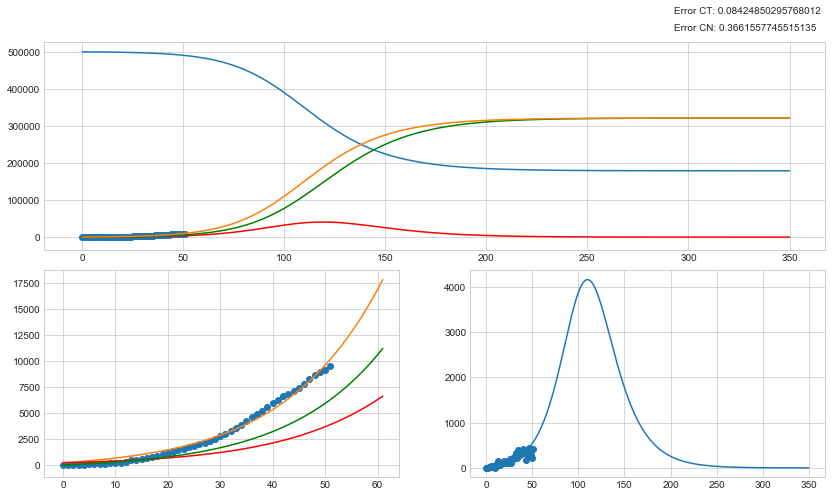

In [11]:
cal_viejos.plotear_fila(12, 350)

In [12]:
cal_viejos.registro.corridas.sum()

372000.0

#### Guardamos los resultados de la primera calibración

In [13]:
beta_viejo = cal_viejos.registro.loc[12].Beta
gamma_viejo = cal_viejos.registro.loc[12].Gamma
sigma_viejo = cal_viejos.registro.loc[12].Sigma
N_viejo = cal_viejos.registro.loc[12].N
v0_viejo = cal_viejos.registro.loc[12].v0
u0_viejo = N_viejo - v0_viejo
w0_viejo = 0
err_CT_viejo = cal_viejos.registro.loc[12].Error_CT
err_CN_viejo = cal_viejos.registro.loc[12].Error_CN

# Calibración de los datos nuevos

In [14]:
cal = AnexoA('AnexoA2_corregido')
cal.registro

,corridas,min_g,max_g,min_s,max_s,min_N,max_N,min_v0,max_v0,Beta,Gamma,Sigma,N,v0,Error_CT,Error_CN
0,15000.0,0.033333,0.037037,2.00,2.08,300000.0,500000.0,650.0,1000.0,0.066667,0.033333,2.000000,300000.000000,900.000000,0.042966,0.202634
1,16875.0,0.033333,0.037037,2.06,2.13,200000.0,300000.0,650.0,800.0,0.069333,0.033333,2.080000,200000.000000,800.000000,0.037284,0.192016
2,45000.0,0.033333,0.037037,1.90,2.10,300000.0,500000.0,650.0,1000.0,0.066829,0.034979,1.910526,300000.000000,1000.000000,0.038742,0.188938
3,20000.0,0.033333,0.037037,1.90,2.10,500000.0,700000.0,650.0,1500.0,0.063333,0.033333,1.900000,500000.000000,1097.368421,0.044833,0.203716
4,20000.0,0.033333,0.037037,2.00,2.10,500000.0,700000.0,650.0,1500.0,0.066667,0.033333,2.000000,500000.000000,828.947368,0.066088,0.270316
5,20000.0,0.033333,0.037037,2.00,2.10,100000.0,300000.0,650.0,1500.0,0.073273,0.034979,2.094737,150000.000000,739.473684,0.033383,0.208175
6,20000.0,0.033333,0.037037,2.00,2.10,250000.0,350000.0,500.0,1000.0,0.066667,0.033333,2.000000,250000.000000,947.368421,0.037242,0.189329
7,20000.0,0.033333,0.037037,2.00,2.10,80000.0,150000.0,500.0,1000.0,0.075634,0.037037,2.042105,150000.000000,710.526316,0.033216,0.209582
8,30000.0,0.060000,0.080000,1.50,2.00,200000.0,400000.0,1.0,1000.0,0.106552,0.071034,1.500000,250000.000000,556.000000,0.030742,0.192656
9,2000.0,0.060000,0.140000,2.00,2.00,200000.0,400000.0,1.0,1000.0,0.120000,0.060000,2.000000,200000.000000,112.000000,0.374041,0.776510


In [15]:
arr_gamma = np.linspace(0.04, 0.05, 26)
arr_sigma = np.linspace(1.6, 2.1, 31)
arr_N = np.linspace(400000, 500000, 1)
arr_v0 = np.linspace(700, 1100, 11)

#cal.agregar_fila(arr_gamma, arr_sigma, arr_N, arr_v0, tol=45000)
#cal.registro

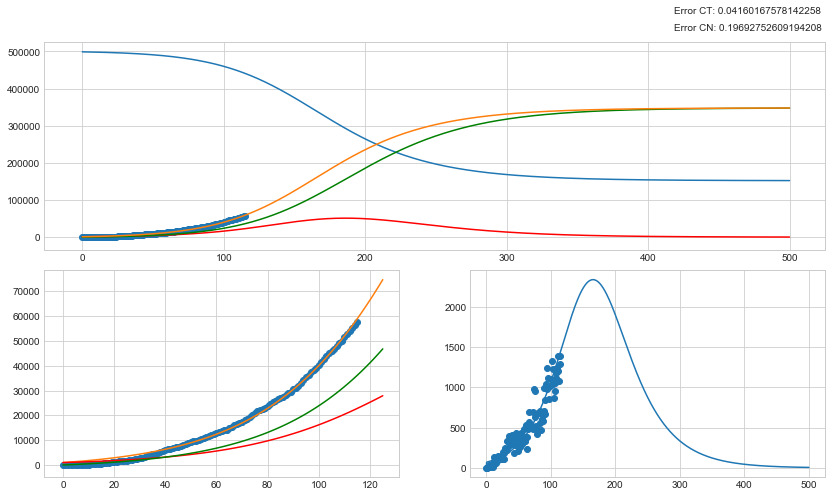

In [16]:
cal.plotear_fila(16, 500)

In [17]:
cal.registro.corridas.sum()

409618.0

#### Guardamos los resultados de la segunda calibración

In [18]:
mejor_beta = cal.registro.loc[16].Beta
mejor_gamma = cal.registro.loc[16].Gamma
mejor_sigma = cal.registro.loc[16].Sigma
mejor_N = cal.registro.loc[16].N
mejor_v0 = cal.registro.loc[16].v0
mejor_u0 = mejor_N - mejor_v0
mejor_w0 = 0
err_CT = cal.registro.loc[16].Error_CT
err_CN = cal.registro.loc[16].Error_CN

def avance_RK2_cal(h=1, dia_max=500):
    '''Función de avance de RK2 pero con los parámetros ya calibrados'''
    return avance_RK2(h=h, beta=mejor_beta, gamma=mejor_gamma, dia_max=dia_max, N=mejor_N, u0=mejor_u0, v0=mejor_v0, w0=mejor_w0)



### Figura 1: Datos viejos Vs. Parámetros viejos

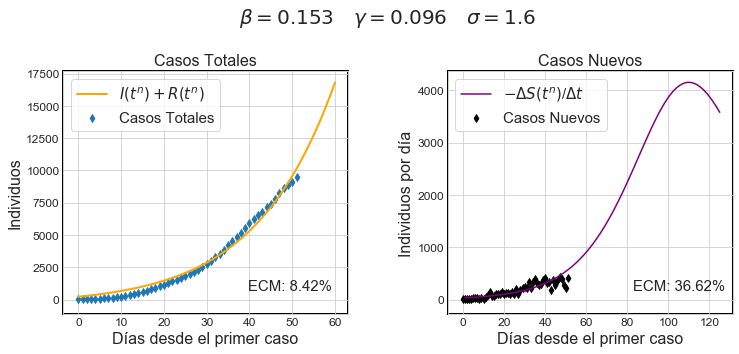

In [19]:
t, u , v, w = avance_RK2(1, beta=beta_viejo, gamma=gamma_viejo, dia_max=60, N=N_viejo, u0=u0_viejo, v0=v0_viejo, w0=w0_viejo)


fig, axs = plt.subplots(1,2, figsize=(12,5))

fig.subplots_adjust(top=0.8, wspace=0.35)

fig.suptitle(r'$\beta = {0} \quad \gamma = {1} \quad \sigma={2}$'.format(round(beta_viejo,3), round(gamma_viejo, 3), round(sigma_viejo, 2)), fontsize=20)

axs[0].plot(t, v + w, c='orange', label=r'$I(t^{n}) + R(t^{n})$', lw=2)
axs[0].scatter(casos_totales.index[:52], casos_totales[:52], label='Casos Totales', s=30, alpha=1, marker='d')
axs[0].set_ylabel('Individuos', fontsize=16)
axs[0].set_xlabel('Días desde el primer caso', fontsize=16)
axs[0].set_title('Casos Totales', fontsize=16)

def calc_deltaS(b, g, N, v0, dia_max):
        t, u , v, w = avance_RK2(1, beta=b, gamma=g, dia_max=dia_max, N=N, u0=N-v0, v0=v0, w0=0)
        deltaS = np.empty(len(t))
        deltaS[0] = v0
        for i in range(1, len(deltaS)):
            deltaS[i] = u[i-1] - u[i]
        return deltaS

deltaS = calc_deltaS(beta_viejo, gamma_viejo, N_viejo, v0_viejo, 125)

axs[1].plot(np.arange(1,126), deltaS[1:], label=r'$- \Delta S(t^{n})}$'+ '/' + r'$\Delta t$', c='purple')
axs[1].scatter(dias[:52], casos_nuevos[:52], label='Casos Nuevos', s=30, marker='d', c='k')
axs[1].set_ylabel('Individuos por día', fontsize=16)
axs[1].set_xlabel('Días desde el primer caso', fontsize=16)
axs[1].set_title('Casos Nuevos', fontsize=16)


errores = [err_CT_viejo, err_CN_viejo]

for i in range(2):
    axs[i].tick_params(labelsize=12)
    axs[i].patch.set_edgecolor('black')  
    axs[i].patch.set_linewidth('2')
    axs[i].legend(frameon=True, fontsize=15)
    axs[i].text(0.65, 0.1, r'ECM: {0}%'.format(round(errores[i] * 100,2)), transform=axs[i].transAxes, size=15)
    

#fig.savefig('Figura2.png')

### Figura 2: SIR parámetros viejos

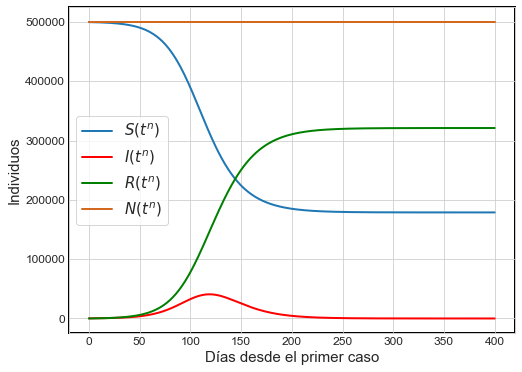

In [20]:
t, u , v, w = avance_RK2(1, beta=beta_viejo, gamma=gamma_viejo, dia_max=400, N=N_viejo, u0=u0_viejo, v0=v0_viejo, w0=w0_viejo)

fig = plt.figure(figsize=(8,6))
ax=plt.axes()


ax.plot(t, u, c='C0', label=r'$S(t^{n})$', lw=2)
ax.plot(t,v, c='red', label= r'$I(t^{n})$', lw=2)
ax.plot(t,w, c='green', label=r'$R(t^{n})$', lw=2)
ax.plot(t, u+v+w, c='chocolate', label=r'$N(t^{n})$', lw=2)
#ax.scatter(casos_totales.index[:52], casos_totales[:52], label='Casos Totales', c='C1', s=50, alpha=0.8)
ax.legend(frameon=True, fontsize=15)
ax.set_ylabel('Individuos', size=15)
ax.set_xlabel('Días desde el primer caso', size=15)
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('2')
ax.tick_params(labelsize=12)

#fig.savefig('Figura3.png')

In [21]:
print(v.max())
print(v.argmax())

pd.to_datetime(fechas.iloc[0]) + pd.Timedelta(119, unit='days')


40763.30629201537
119


Timestamp('2020-06-29 00:00:00')

### Figura 3: Datos nuevos Vs. Parámetros viejos

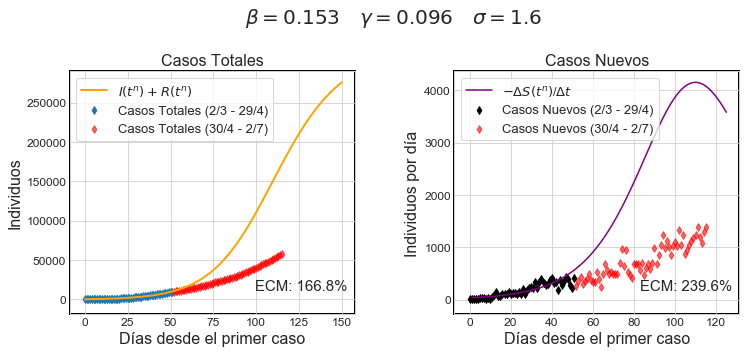

In [22]:
t, u , v, w = avance_RK2(1, beta=beta_viejo, gamma=gamma_viejo, dia_max=150, N=N_viejo, u0=u0_viejo, v0=v0_viejo, w0=w0_viejo)

fig, axs = plt.subplots(1,2, figsize=(12,5))

fig.subplots_adjust(top=0.8, wspace=0.35)

fig.suptitle(r'$\beta = {0} \quad \gamma = {1} \quad \sigma={2}$'.format(round(beta_viejo,3), round(gamma_viejo, 3), round(sigma_viejo, 2)), fontsize=20)

axs[0].plot(t, v + w, c='orange', label=r'$I(t^{n}) + R(t^{n})$', lw=2)
axs[0].scatter(casos_totales.index[:52], casos_totales[:52], label='Casos Totales (2/3 - 29/4)', s=30, alpha=1, marker='d')
axs[0].scatter(casos_totales.index[52:], casos_totales[52:], label='Casos Totales (30/4 - 2/7)', s=30, alpha=0.6, marker='d', c='red')
axs[0].set_ylabel('Individuos', fontsize=16)
axs[0].set_xlabel('Días desde el primer caso', fontsize=16)
axs[0].set_title('Casos Totales', fontsize=16)

def calc_deltaS(b, g, N, v0, dia_max):
        t, u , v, w = avance_RK2(1, beta=b, gamma=g, dia_max=dia_max, N=N, u0=N-v0, v0=v0, w0=0)
        deltaS = np.empty(len(t))
        deltaS[0] = v0
        for i in range(1, len(deltaS)):
            deltaS[i] = u[i-1] - u[i]
        return deltaS

deltaS = calc_deltaS(beta_viejo, gamma_viejo, N_viejo, v0_viejo, 125)

axs[1].plot(np.arange(1,126), deltaS[1:], label=r'$- \Delta S(t^{n})}$'+ '/' + r'$\Delta t$', c='purple')
axs[1].scatter(dias[:52], casos_nuevos[:52], label='Casos Nuevos (2/3 - 29/4)', s=30, marker='d', c='k')
axs[1].scatter(dias[52:], casos_nuevos[52:], label='Casos Nuevos (30/4 - 2/7)', s=30, marker='d', c='red', alpha=0.6)
axs[1].set_ylabel('Individuos por día', fontsize=16)
axs[1].set_xlabel('Días desde el primer caso', fontsize=16)
axs[1].set_title('Casos Nuevos', fontsize=16)


errores = [error(casos_totales, v+w, 1, 116) , error(casos_nuevos, deltaS, 1, 116)]

for i in range(2):
    axs[i].tick_params(labelsize=12)
    axs[i].patch.set_edgecolor('black')  
    axs[i].patch.set_linewidth('2')
    axs[i].legend(frameon=True, fontsize=13)
    axs[i].text(0.65, 0.1, r'ECM: {0}%'.format(round(errores[i] * 100,1)), transform=axs[i].transAxes, size=15)

#fig.savefig('Figura4.png')


### Figura 4: Datos nuevos, parámetros nuevos

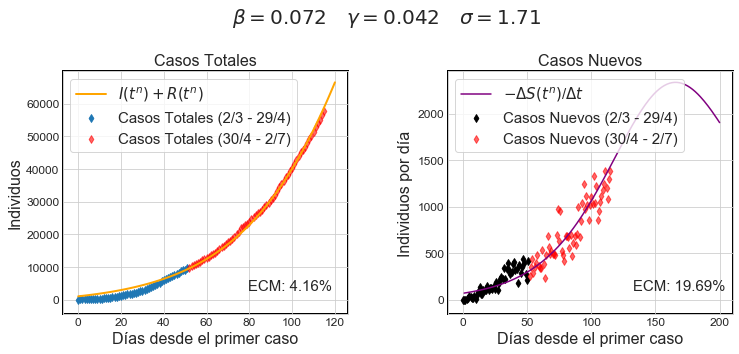

In [23]:
t, u , v, w = avance_RK2_cal(1, dia_max=120)


fig, axs = plt.subplots(1,2, figsize=(12,5))

fig.subplots_adjust(top=0.8, wspace=0.35)

fig.suptitle(r'$\beta = {0} \quad \gamma = {1} \quad \sigma={2}$'.format(round(mejor_beta,3), round(mejor_gamma, 3), round(mejor_sigma, 2)), fontsize=20)

axs[0].plot(t, v + w, c='orange', label=r'$I(t^{n}) + R(t^{n})$', lw=2)
axs[0].scatter(casos_totales.index[:52], casos_totales[:52], label='Casos Totales (2/3 - 29/4)', s=30, alpha=1, marker='d')
axs[0].scatter(casos_totales.index[52:], casos_totales[52:], label='Casos Totales (30/4 - 2/7)', s=30, alpha=0.6, marker='d', c='red')
axs[0].set_ylabel('Individuos', fontsize=16)
axs[0].set_xlabel('Días desde el primer caso', fontsize=16)
axs[0].set_title('Casos Totales', fontsize=16)

def calc_deltaS(b, g, N, v0, dia_max):
        t, u , v, w = avance_RK2(1, beta=b, gamma=g, dia_max=dia_max, N=N, u0=N-v0, v0=v0, w0=0)
        deltaS = np.empty(len(t))
        deltaS[0] = v0
        for i in range(1, len(deltaS)):
            deltaS[i] = u[i-1] - u[i]
        return deltaS

deltaS = calc_deltaS(mejor_beta, mejor_gamma, mejor_N, mejor_v0, 200)

axs[1].plot(np.arange(1,201), deltaS[1:], label=r'$- \Delta S(t^{n})}$'+ '/' + r'$\Delta t$', c='purple')
axs[1].scatter(dias[:52], casos_nuevos[:52], label='Casos Nuevos (2/3 - 29/4)', s=30, marker='d', c='k')
axs[1].scatter(dias[52:], casos_nuevos[52:], label='Casos Nuevos (30/4 - 2/7)', s=30, marker='d', c='red', alpha=0.6)
axs[1].set_ylabel('Individuos por día', fontsize=16)
axs[1].set_xlabel('Días desde el primer caso', fontsize=16)
axs[1].set_title('Casos Nuevos', fontsize=16)


errores = [err_CT, err_CN]

for i in range(2):
    axs[i].tick_params(labelsize=12)
    axs[i].patch.set_edgecolor('black')  
    axs[i].patch.set_linewidth('2')
    axs[i].legend(frameon=True, fontsize=15)
    axs[i].text(0.65, 0.1, r'ECM: {0}%'.format(round(errores[i] * 100,2)), transform=axs[i].transAxes, size=15)
    


#fig.savefig('Figura5.png')

In [24]:
t, u1 , v1, w1 = avance_RK2_cal(0.1, dia_max=400)
t, u , v, w = avance_RK2_cal(1, dia_max=399)

res = w1[[n*10 for n in range(400)]]

ecm_rel(res, w)

4.45085953510158e-05

### Figura 5: SIR parámetros nuevos

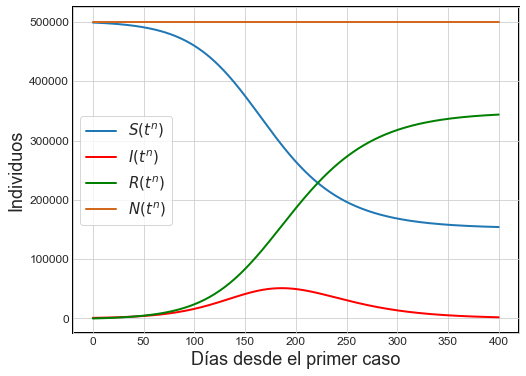

In [25]:
t, u , v, w = avance_RK2_cal(1, dia_max=400)

fig = plt.figure(figsize=(8,6))
ax=plt.axes()


ax.plot(t, u, c='C0', label=r'$S(t^{n})$', lw=2)
ax.plot(t,v, c='red', label= r'$I(t^{n})$', lw=2)
ax.plot(t,w, c='green', label=r'$R(t^{n})$', lw=2)
ax.plot(t, u+v+w, c='chocolate', label=r'$N(t^{n})$', lw=2)
ax.legend(frameon=True, fontsize=15)
ax.set_ylabel('Individuos', size=18)
ax.set_xlabel('Días desde el primer caso', size=18)
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('2')
ax.tick_params(labelsize=12)

#fig.savefig('Figura6.png')

In [26]:
v.max()
v.argmax()

186

# Función de avance del PVI (método Crank-Nicholson)

In [27]:
def avance_CN_Gauss_Seidel(h, dia_max, beta=mejor_beta, gamma=mejor_gamma, N=mejor_N, u0=mejor_u0, v0=mejor_v0, w0=0, tol=1e-5):
    
    t = np.arange(0, dia_max+h, h)
    u = np.empty(len(t))
    u[0] = u0
    v = np.empty(len(t))
    v[0] = v0
    w = np.empty(len(t))
    w[0] = w0
    
    def g1(x, y, n):
        return u[n] - h/2 * beta / N *(x * y + u[n]*v[n]) 
    def g2(x, y, n):
        return v[n] + h/2 * (beta / N * (x*y + u[n]*v[n]) - gamma*(y + v[n]))  
    
    for n in range(len(t)-1):
        x = u[n]
        y = v[n]
        err = tol * 1.1
        
        while err > tol:
            
            x_sig = g1(x, y, n)
            y_sig = g2(x_sig, y, n)
            
            err = max(np.abs(x - x_sig), np.abs(y - y_sig))
            
            x = x_sig
            y = y_sig
        
        u[n+1] = x
        v[n+1] = y
        w[n+1] = w[n] + h/2 * gamma* (v[n+1] + v[n])
             
    return t, u, v, w

# Comparación gráfica de los métodos

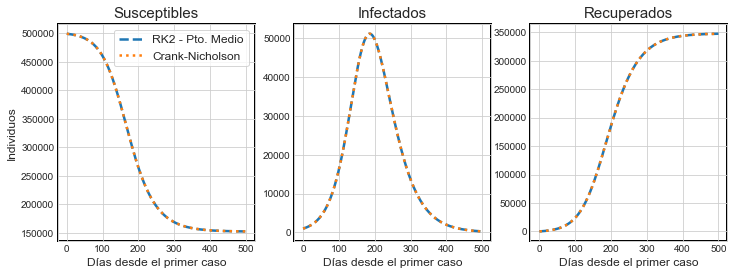

In [28]:
def graficar_metodos():
    fig, axs = plt.subplots(1,3,figsize=(12,4), sharex=True)

    clases = ['Susceptibles', 'Infectados', 'Recuperados']

    t1, u1, v1, w1 = avance_RK2_cal(h=0.1, dia_max=500)
    t2, u2 , v2, w2 = avance_CN_Gauss_Seidel(h=0.1, dia_max=500, tol=1e-5)

    datos_A = [u1, v1, w1]
    datos_B = [u2, v2, w2]

    for i in range(3):
        axs[i].plot(t1, datos_A[i], ls='--', label='RK2 - Pto. Medio', lw=2.5)
        axs[i].plot(t2, datos_B[i], ls=':', label='Crank-Nicholson', lw=2.5)
        axs[i].set_title(clases[i], size=15)
        axs[i].set_xlabel('Días desde el primer caso', size=12)
        axs[i].patch.set_edgecolor('black')  
        axs[i].patch.set_linewidth('2') 
        

        
    axs[0].set_ylabel('Individuos', size=12)
    axs[0].legend(frameon=True, fontsize=12, loc='upper right')

    #fig.savefig('Figura7.png')
    return

graficar_metodos()
        

In [29]:
t, u , v, w = avance_RK2_cal(0.1, dia_max=400)

#t2, u2 , v2, w2 = avance_CN_Gauss_Seidel(0.1, dia_max=400, tol=0.1)

t2, u2 , v2, w2 = avance_CN_Gauss_Seidel(0.1, dia_max=400, tol=1e-10)

print(max(ecm_rel(u, u2), ecm_rel(v, v2), ecm_rel(w, w2)))


1.249344903266993e-06


# Aproximación del valor del pico de contagios

In [30]:
t, u , v, w = avance_RK2_cal(0.1, dia_max=400)

def i_max(sigma=mejor_sigma, u0=mejor_u0, v0=mejor_v0, N=mejor_N):
    return (u0 + v0)/N - 1/sigma - 1/sigma*np.log(sigma * u0 / N)

i_max_T = i_max(mejor_sigma)  #Valor teórico del pico de infectados normalizado
i_max_N = v.max() / mejor_N         #Valor numérico


print(i_max_T)
print(i_max_N)
print(np.abs(i_max_N - i_max_T) / i_max_T)

0.1022475573461138
0.10224757675350518
1.8980787308881968e-07


# ENL Para $\large{s_{\infty}}$

In [31]:
def newton_raphson(x0, g, tol):
    x_sig = g(x0)
    x = x0
    while np.abs(x_sig - x) > tol:
        x = x_sig
        x_sig = g(x_sig)
    return x_sig

def funcion_iteradora(x, i0=(mejor_v0/mejor_N), s0=(mejor_u0/mejor_N), sigma=mejor_sigma):
    return x - (i0 + s0 - x + 1/sigma*np.log(x/s0)) / (-1 + 1/(sigma*x))

s_inf_T = newton_raphson(0.3, funcion_iteradora, 1e-10)

s_inf_T

0.30399851674691414

### Figura 8: $\large{s_{\infty}}$

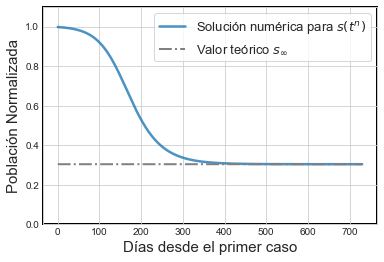

In [32]:
t, u , v, w = avance_RK2_cal(0.1, dia_max=365*2)

fig = plt.figure()
ax = plt.axes()

ax.plot(t, u/mejor_N, label= r'Solución numérica para $s(t^{n})$', lw=2.5, alpha=0.8)
ax.plot(t, np.full(len(t), s_inf_T), ls='-.', c='gray', label=r'Valor teórico $s_{\infty}$', lw=2)
ax.set_ylim(0,1.1)
ax.set_xlabel('Días desde el primer caso', size=15)
ax.set_ylabel('Población Normalizada', size=15)
ax.legend(frameon=True, fontsize=13)

ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('2')


#fig.savefig('Figura8.png')


In [33]:
t, u , v, w = avance_RK2_cal(0.1, dia_max=3650)

s_365_N = u[3650] / mejor_N
s_548_N = u[5480] / mejor_N
s_730_N = u[7300] / mejor_N
s_730_N = u[7300] / mejor_N
s_1000_N = u[9999] / mejor_N
s_3650_N = u[36499] / mejor_N



print(s_inf_T)
print(s_365_N)
print(np.abs(s_365_N - s_inf_T) / s_inf_T)
print(s_730_N)
print(np.abs(s_730_N - s_inf_T) / s_inf_T)
print(s_3650_N)
print(np.abs(s_3650_N - s_inf_T) / s_inf_T)


0.30399851674691414
0.31287756757078156
0.029207546533062314
0.30400395867866004
1.7901178611434186e-05
0.3039985529557298
1.1910852742140132e-07


# Aproximación de Sigma

In [34]:
def sigma_aprox(s_inf):
    return np.log(mejor_u0/mejor_N/s_inf) / (mejor_u0/mejor_N - s_inf)

print('sigma aprox:', sigma_aprox(s_3650_N))
print('Mejor sigma:', mejor_sigma)

sigma aprox: 1.7128233758234377
Mejor sigma: 1.7080000000000002


In [35]:
i_max(sigma_aprox(s_3650_N)) * mejor_N

51564.625899275045

In [36]:
i_max(mejor_sigma) * mejor_N

51123.7786730569

# Conservación de N (Ambos métodos)

### Figura 9

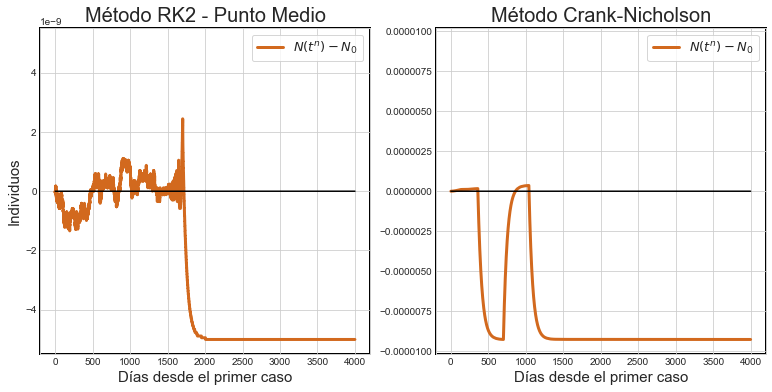

In [37]:
t, u , v, w = avance_RK2_cal(0.1, dia_max=4000)
t2, u2 , v2, w2 = avance_CN_Gauss_Seidel(0.1, dia_max=4000, tol=1e-5)

fig, axs = plt.subplots(1, 2,figsize=(13,6), sharex=True)

axs[0].plot(t, u+v+w - mejor_N, c='chocolate', lw=3)
axs[0].set_ylabel('Individuos', size=15)

y0lim_abs = np.abs((u+v+w) - mejor_N).max() * 1.1
axs[0].set_ylim(top=y0lim_abs, bottom=-(y0lim_abs))

axs[1].plot(t2, u2+v2+w2 - mejor_N, c='chocolate', lw=3)

y1lim_abs = np.abs((u2+v2+w2) - mejor_N).max() * 1.1
axs[1].set_ylim(top=y1lim_abs, bottom=-(y1lim_abs))
#axs[1].set_yticks([100*n for n in range(-5,6)])

titulos = ['Método RK2 - Punto Medio', 'Método Crank-Nicholson']

for i in range(len(axs)):
    axs[i].plot(t, np.zeros(len(t)), 'k')
    axs[i].legend([r"$ N(t^{n}) - N_{0} $"], frameon=True, fontsize=13)
    axs[i].set_title(titulos[i], size=20)
    axs[i].set_xlabel('Días desde el primer caso', size=15)
    axs[i].patch.set_edgecolor('black')  
    axs[i].patch.set_linewidth('2')


    
#fig.savefig('Figura9.png')

# Orden Método A

In [38]:
class Solucion_Numerica:
    
    def __init__(self, arr, h):
        self.arr = np.array(arr)
        self.h = h
    
    def __getitem__(self, dia):
        return self.arr[int(dia/self.h)]
    
    def comparar(self, dia, other):
        return np.abs(self[dia] - other[dia])


href = 2**(-10)
ref_A = avance_RK2_cal(href, dia_max=300)

uref_A = Solucion_Numerica(ref_A[1], href)
vref_A = Solucion_Numerica(ref_A[2], href)
wref_A = Solucion_Numerica(ref_A[3], href)

def orden_metodo_A(hmax, hmin, dia, uref=uref_A, vref=vref_A, wref=wref_A):
    paso = np.array([2**n for n in range(hmax, hmin, -1)])
    error_u = np.empty(hmax - hmin)
    error_v = np.empty(hmax - hmin)
    error_w = np.empty(hmax - hmin)
    for i in range(len(paso)):
        h = paso[i]
        sol = avance_RK2_cal(h, dia_max=300)
        u = Solucion_Numerica(sol[1], h)
        v = Solucion_Numerica(sol[2], h)
        w = Solucion_Numerica(sol[3], h)
        error_u[i] = round(u.comparar(dia, uref),6)
        error_v[i] = round(v.comparar(dia, vref),6)
        error_w[i] = round(w.comparar(dia, wref),6)
    
    resultado = pd.DataFrame({'Error S': error_u, 'Error I': error_v, 'Error R': error_w}, index=paso)
    resultado.index.name = r'$h$'
    return resultado

In [39]:
tabla1 = orden_metodo_A(3, -7, 200)

pd.set_option("display.precision", 6)
#tabla1.to_csv("Tabla1.csv")

tabla1

,Error S,Error I,Error R
$h$,,,
8.000000,692.314133,140.108998,832.423130
4.000000,191.603749,35.336516,226.940265
2.000000,50.531664,8.907082,59.438745
1.000000,12.983495,2.238082,15.221576
0.500000,3.291120,0.561071,3.852191
0.250000,0.828519,0.140469,0.968988
0.125000,0.207845,0.035141,0.242986
0.062500,0.052043,0.008787,0.060830
0.031250,0.013012,0.002196,0.015208


# Orden Método B

In [40]:
href = 2**(-10)
ref_B = avance_CN_Gauss_Seidel(href, dia_max=300)

uref_B = Solucion_Numerica(ref_B[1], href)
vref_B = Solucion_Numerica(ref_B[2], href)
wref_B = Solucion_Numerica(ref_B[3], href)

def orden_metodo_B(hmax, hmin, dia, uref=uref_B, vref=vref_B, wref=wref_B, tol=1e-5):
    paso = np.array([2**n for n in range(hmax, hmin, -1)])
    error_u = np.empty(hmax - hmin)
    error_v = np.empty(hmax - hmin)
    error_w = np.empty(hmax - hmin)
    for i in range(len(paso)):
        h = paso[i]
        sol = avance_CN_Gauss_Seidel(h, dia_max=300, tol=tol)
        u = Solucion_Numerica(sol[1], h)
        v = Solucion_Numerica(sol[2], h)
        w = Solucion_Numerica(sol[3], h)
        error_u[i] = round(u.comparar(dia, uref),6)
        error_v[i] = round(v.comparar(dia, vref),6)
        error_w[i] = round(w.comparar(dia, wref),6)
    
    resultado = pd.DataFrame({'Error S': error_u, 'Error I': error_v, 'Error R': error_w}, index=paso)
    resultado.index.name = r'$h$'
    return resultado

In [41]:
tabla2 = orden_metodo_B(3, -7, 200, tol=1e-5)

pd.set_option("display.precision", 6)


#tabla2.to_csv('Tabla2.csv')
tabla2

,Error S,Error I,Error R
$h$,,,
8.000000,120.624308,98.912252,219.536559
4.000000,29.954464,24.769260,54.723722
2.000000,7.475969,6.194897,13.670863
1.000000,1.868187,1.548883,3.417068
0.500000,0.467032,0.387234,0.854262
0.250000,0.116749,0.096807,0.213556
0.125000,0.029219,0.024204,0.053418
0.062500,0.007279,0.006047,0.013323
0.031250,0.001840,0.001513,0.003350


In [42]:
def cm_discreto(f, phis, x, pot=False):
    '''
    Devuelve la funcion de ajuste y sus parametros
    
    Parametros:
    
        f: valores de la funcion a aproximar
        phis: lista con las funciones generadoras
        x: intervalo discreto de f
        pot: True si es una funcion potencial
    '''
    N = len(phis)
    PHI = np.empty((N, len(x))) #matriz que va a tener los datos de cada phi evaluado en todos los x
    for i in range(N):          #carga de la matriz
        PHI[i] = phis[i](x)
    
    M = np.empty((N,N))         #matriz de ecuaciones normales
    for i in range(N):
        for j in range(N):
            M[i,j] = np.dot(PHI[i], PHI[j])
    
    if pot == False:
        b = np.array([np.dot(phii, f) for phii in PHI]) #vector independient3
    else: 
        b = np.array([np.dot(phii, np.log(f)) for phii in PHI])
    
    C = np.linalg.solve(M,b)   #solucion SEL Ax=b    
    
    if pot == False:
        if N == 2:
            f = lambda x: C[0]*phis[0](x) + C[1]*phis[1](x)
            return f, [C[0], C[1]]
        elif N == 3: 
            f = lambda x: C[0]*phis[0](x) + C[1]*phis[1](x) + C[2]*phis[2](x)
            return f, [C[0], C[1], C[2]]
        elif N == 4:
            f = lambda x: C[0]*phis[0](x) + C[1]*phis[1](x) + C[2]*phis[2](x) + C[3]*phis[3](x)
            return f, [C[0], C[1], C[2], C[3]]
    else: 
        f = lambda x:  np.exp(C[0]*phis[0](x) + C[1]*phis[1](x))
        return f, [np.exp(C[0]), C[1]]           #Devuelve la funcion y sus parametros

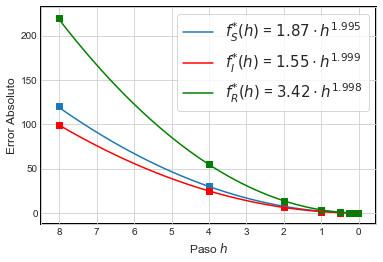

In [63]:
def orden(tabla):    
    colors = ['C0', 'red', 'green']
    labels = [r'$f^{*}_{S}(h)$', r'$f^{*}_{I}(h)$', r'$f^{*}_{R}(h)$']
    fig, ax = plt.subplots()
    phis = [lambda x: x-x+1, lambda x: x]
    t=np.linspace(0,8,100)
    X = np.array(tabla2.index)
    for i in range(3):
        Y = np.array(tabla.iloc[:,i])
        f, p = cm_discreto(np.log(Y), phis, np.log(X))
        f = lambda x: np.exp(p[0]) * x**p[1]
        
        A = round(np.exp(p[0]),2)
        P = round(p[1],3)
        
        label = labels[i] + ' = $ %s \cdot h^{ %s }$' % (A, P)
        
        ax.scatter(X,Y, c=colors[i], s=30, marker='s')
        ax.plot(t, f(t), c=colors[i], label=label)
        
    
    ax.legend(frameon=True, fontsize=15)
    ax.invert_xaxis()
    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth('2')
    ax.set_ylabel('Error Absoluto', fontsize=12)
    ax.set_xlabel(r'Paso $h$', fontsize=12)


    return fig

figura10 = orden(tabla2)

#figura10.savefig('Figura10.png')


# Costo Computacional (Ambos métodos)

In [44]:
import datetime

def cronometro(h, metodo, runs, loops, tol=1e-5):
    '''Registra el tiempo que tarda el método A o B en resolver el PVI y devuelve la informacion necesaria
    para construir una flia de la Tabla 3'''
    tiempos = np.empty(runs)
    
    if metodo.upper() == 'A':
        tol = np.nan
        for r in range(runs):
            iniciar = datetime.datetime.now()
            for l in range(loops):
                x = avance_RK2_cal(h, dia_max=300)
            terminar = datetime.datetime.now()

            delta = terminar - iniciar
            tiempos[r] = delta.total_seconds() / loops * 1000

    else:
        for r in range(runs):
            iniciar = datetime.datetime.now()
            for l in range(loops):
                x = avance_CN_Gauss_Seidel(h, dia_max=300, tol=tol)
            terminar = datetime.datetime.now()

            delta = terminar - iniciar
            tiempos[r] = delta.total_seconds() / loops * 1000
    
    media = round(tiempos.mean(),2)
    std = round(tiempos.std(),2)
    
    tiempo = r'$ {0} \pm {1}$'.format(media, std)
    
    s1 = 's'
    if runs == 1: s1 = ''
    
    s2 = 's'
    if loops == 1: s2=''
    descr = f'{runs} vuelta{s1} de {loops} corrida{s2}'
    return [eval(repr(metodo)), h, tol, tiempo, descr]

In [45]:
cronometro(0.1,'B', 7, 10)

['B', 0.1, 1e-05, '$ 133.86 \\pm 13.52$', '7 vueltas de 10 corridas']

In [46]:
class TablaCrono():
    
    def __init__(self):
        self.tabla = pd.DataFrame({'Método': [], 'Paso': [], 'Tolerancia': [], 'Tiempo medio (ms)': [], 'Descripción': [] })
        self.nfilas = 0
    
    def agregar_fila(self, h, metodo, runs, loops, tol=1e-5):
        self.tabla.loc[self.nfilas+1] = cronometro(h, metodo, runs, loops, tol)
        self.nfilas +=1
        return self.tabla
    
    def show(self):
        return self.tabla
    
    def guardar(self):
        self.tabla.to_csv('Tabla3.csv')
        print('Tabla guardada como "Tabla3.csv"')
        return
    
tabla3 = TablaCrono()

pd.set_option("display.precision", 2)

tabla3.agregar_fila(1,'A', 7, 100)
tabla3.agregar_fila(0.1,'A', 7, 10)
tabla3.agregar_fila(0.01,'A', 7, 1)
tabla3.agregar_fila(0.001,'A', 1, 1)

tabla3.agregar_fila(0.1,'B', 7, 10,tol=1e-5)
tabla3.agregar_fila(0.01,'B', 7, 1,tol=1e-5)
tabla3.agregar_fila(0.001,'B', 1, 1,tol=1e-5)

tabla3.agregar_fila(1,'B', 7, 100,tol=1e-1)
tabla3.agregar_fila(1,'B', 7, 100,tol=1e-5)
tabla3.agregar_fila(1,'B', 7, 100,tol=1e-10)

#tabla3.guardar()
tabla3.show()

#Esta tabla no coincide con la presentada en el tp porque se volvió a correr el programa y lógicamente se obtuvieron otros resultados.
#De todas formas puede verse que el análisis hecho en el informe también vale para estos valores

,Método,Paso,Tolerancia,Tiempo medio (ms),Descripción
1,A,1.00e+00,NaN,$ 3.17 \pm 0.16$,7 vueltas de 100 corridas
2,A,1.00e-01,NaN,$ 27.78 \pm 1.0$,7 vueltas de 10 corridas
3,A,1.00e-02,NaN,$ 275.12 \pm 10.21$,7 vueltas de 1 corrida
4,A,1.00e-03,NaN,$ 2903.24 \pm 0.0$,1 vuelta de 1 corrida
5,B,1.00e-01,1.00e-05,$ 122.24 \pm 2.38$,7 vueltas de 10 corridas
6,B,1.00e-02,1.00e-05,$ 952.73 \pm 36.57$,7 vueltas de 1 corrida
7,B,1.00e-03,1.00e-05,$ 7491.0 \pm 0.0$,1 vuelta de 1 corrida
8,B,1.00e+00,1.00e-01,$ 10.04 \pm 0.2$,7 vueltas de 100 corridas
9,B,1.00e+00,1.00e-05,$ 15.79 \pm 0.22$,7 vueltas de 100 corridas
10,B,1.00e+00,1.00e-10,$ 24.06 \pm 1.09$,7 vueltas de 100 corridas


In [47]:
#tabla3.guardar()

# Estabilidad Empírica

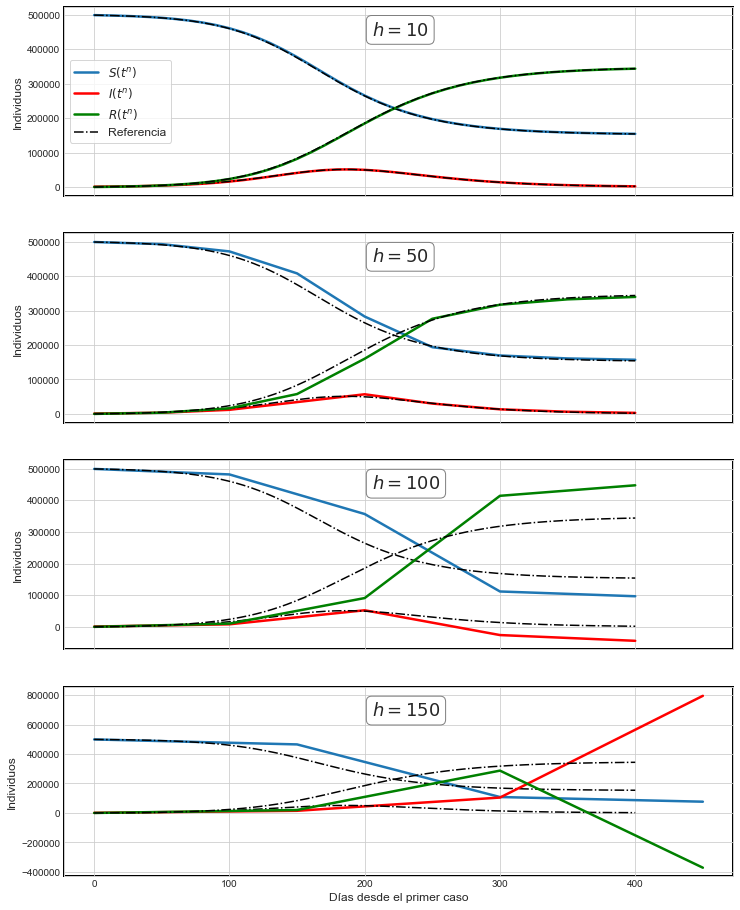

In [48]:
def graficar_metodos_2(pasos, dia_max):
    fig, axs = plt.subplots(len(pasos),1,figsize=(12,4 * len(pasos)), sharex=True)

    clases = ['Susceptibles', 'Infectados', 'Recuperados']
    color = ['C0', 'red', 'green']
    labels = [r'$S(t^{n})$', r'$I(t^{n})$', r'$R(t^{n})$', 'Referencia', '', '']
    sol_ref = avance_CN_Gauss_Seidel(h=0.1, dia_max=dia_max)
    
    for i in range(len(axs)):
        sol = avance_RK2_cal(h=pasos[i], dia_max=dia_max)
        axs[i].patch.set_edgecolor('black')  
        axs[i].patch.set_linewidth('2') 
        axs[i].text(0.46, 0.85, r'$h={0}$'.format(pasos[i]), fontsize=18, transform=axs[i].transAxes, bbox=dict(boxstyle="round", fc="none", ec="gray"))
        axs[i].set_ylabel('Individuos', fontsize=12)
        for j in range(3):
            axs[i].plot(sol[0], sol[j+1], lw=2.5, c=color[j], label = labels[j])
            axs[i].plot(sol_ref[0], sol_ref[j+1],c='k', ls='-.', label=labels[j+3])


           
    axs[len(pasos)-1].set_xlabel('Días desde el primer caso', size=12)
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0,2,3,1]
    axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=True, fontsize=12, loc='center left')
    

    #fig.savefig('Figura1.png')
    return

graficar_metodos_2([10,50,100, 150], 400)

# Anexo B.1

In [49]:
dias = [50, 100, 150, 300]

for i in range(4):
    tablaA = orden_metodo_A(3, -7, dias[i])
    #tablaA.to_csv(f'TablaC1{i+1}.csv')

# Anexo B.2

In [50]:
dias = [50, 100, 150, 300]

for i in range(4):
    tablaB = orden_metodo_A(3, -7, dias[i])
    #tablaB.to_csv(f'TablaC2{i+1}.csv')

# Espacio de Fase

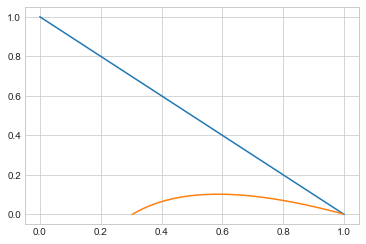

In [51]:
t, u , v, w = avance_RK2_cal(0.1, dia_max=800)

fig = plt.Figure()

ax = plt.axes()

ax.plot([0,1], [1,0])
ax.plot(u/mejor_N, v/mejor_N)

def flechita(locs):
    for i in locs:
        plt.arrow(u[i], v[i], u[i+100], v[i+100] - v[i], shape='full', lw=0, length_includes_head=True, head_width=.05)
    return

#flechita([2000])

#### En estas células les hacemos un par de cambios viusales a las DataFrames de los Anexos A para que entren en la hoja del pdf

In [52]:
df1 = cal_viejos.registro.copy()

df1.columns = ['Corridas', 'Min g', 'Max g', 'Min s', 'Max s', 'Min N', 'Max N',
       'Min v0', 'Max v0', 'Beta', 'Gamma', 'Sigma', 'N', 'v0', 'Error CT',
       'Error CN']

df1 = df1.astype({'Corridas': 'int32', 'Min N':'int32', 'Max N':'int32',
       'Min v0':'int32', 'Max v0':'int32', 'N':'int32', 'v0':'int32'})
df1 = df1.round({'Min g': 3, 'Max g': 3, 'Min s': 2, 'Max s': 2, 'Beta': 3, 
                 'Gamma': 4, 'Sigma': 4,'Error CT': 4, 'Error CN': 4})
df1.index = df1.Corridas

df1 = df1.drop('Corridas', axis=1)

#df1.to_csv('AnexoA1.csv')


In [53]:
df2 = cal.registro.copy()

df2.columns = ['Corridas', 'Min g', 'Max g', 'Min s', 'Max s', 'Min N', 'Max N',
       'Min v0', 'Max v0', 'Beta', 'Gamma', 'Sigma', 'N', 'v0', 'Error CT',
       'Error CN']

df2 = df2.astype({'Corridas': 'int32', 'Min N':'int32', 'Max N':'int32',
       'Min v0':'int32', 'Max v0':'int32', 'N':'int32', 'v0':'int32'})
df2 = df2.round({'Min g': 3, 'Max g': 3, 'Min s': 2, 'Max s': 2, 'Beta': 3, 
                 'Gamma': 4, 'Sigma': 4,'Error CT': 4, 'Error CN': 4})
df2.index = df2.Corridas

df2 = df2.drop('Corridas', axis=1)

#df2.to_csv('AnexoA2.csv')